# fit $p(\theta, z | \{ x_i \})$ using SEDflow posteriors

In [1]:
import os
import numpy as np

In [2]:
from sedflow import obs as Obs

In [3]:
from nflows import transforms, distributions, flows

In [4]:
import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [5]:
import corner as DFM
import matplotlib.pyplot as plt

In [6]:
device = torch.device(type='cuda', index=0)

In [7]:
#dat_dir = '/tigress/chhahn/sedflow/'
dat_dir = '/scratch/network/chhahn/sedflow/'
fpost = os.path.join(dat_dir, 'anpe_thetaunt_magsigz.toy.500x15.2.nsa0of34.samples.npy')
post = np.load(fpost)

In [10]:
y_nsa = Obs.load_nsa_data(test_set=False)

ichunk = 0 
igals = np.arange(y_nsa.shape[0])[ichunk*1000:(ichunk+1)*1000]
zreds = y_nsa[igals,-1]
zreds = np.tile(zreds[:,None].T, (10000, 1)).T

In [11]:
x_data = torch.tensor(np.concatenate([post, zreds[:,:,None]], axis=2)).to(device)

In [12]:
avg_post = torch.sum(torch.sum(x_data, axis=0), axis=0)/x_data.shape[0]/x_data.shape[1]
std_post = torch.std(x_data.reshape(x_data.shape[0]*x_data.shape[1], x_data.shape[2]), axis=0)

In [13]:
w_post = (x_data - avg_post)/std_post

In [14]:
ndim = x_data.shape[-1]

In [15]:
def Loss(flow, post): 
    return -torch.sum(torch.logsumexp(flow.log_prob(post.reshape(post.shape[0]*100, post.shape[2])).reshape(post.shape[0], 100), axis=1) - torch.log(torch.tensor(100.)))

In [16]:
nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

blocks = []
for iblock in range(5): 
    blocks += [
        transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
        transforms.RandomPermutation(features=ndim)
    ]

transform = transforms.CompositeTransform(blocks)

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[ndim])


# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)
#flow.to(device)

In [17]:
all_flows = []

lr = 1e-3
num_iter = 1000
patience = 20

best_valid_losses, valid_losseses = [], []
for i in range(10): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

    blocks = []
    for iblock in range(5): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
            transforms.RandomPermutation(features=ndim)
        ]

    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])


    # Combine into a flow.
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # weights = torch.ones(ncomp, requires_grad=True)
    # means = torch.tensor(np.random.randn(ncomp, ndim), requires_grad=True)
    # stdevs = torch.tensor(np.abs(torch.rand(ncomp, ndim)), requires_grad=True)

    # parameters = [weights, means, stdevs]
    optimizer1 = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer1, lr, total_steps=num_iter)

    best_epoch = 0 
    best_valid_loss = np.inf
    valid_losses = []
    for epoch in range(num_iter):
        train_loss = 0.
        for ii in range(90): 
            optimizer1.zero_grad()
            loss = Loss(flow, w_post[:,ii::100,:])
            loss.backward()
            train_loss += loss.item()
            optimizer1.step()
        train_loss = train_loss/90.

        with torch.no_grad():
            valid_loss = 0.
            for ii in range(10): 
                loss = Loss(flow, w_post[:,90+ii::100,:])
                valid_loss += loss.item()
            valid_loss = valid_loss/10.            
            valid_losses.append(valid_loss)
            if epoch % 20 == 0: 
                print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
                    
        scheduler.step()
    all_flows.append(flow)
    valid_losseses.append(valid_losses)

0 	 3.08e+04 	 2.81e+04
20 	 1.38e+04 	 1.38e+04
40 	 1.35e+04 	 1.35e+04
60 	 1.33e+04 	 1.34e+04
80 	 1.32e+04 	 1.33e+04
100 	 1.31e+04 	 1.32e+04
120 	 1.31e+04 	 1.31e+04
140 	 1.30e+04 	 1.31e+04
160 	 1.29e+04 	 1.31e+04
180 	 1.29e+04 	 1.30e+04
200 	 1.28e+04 	 1.30e+04
220 	 1.28e+04 	 1.29e+04
240 	 1.27e+04 	 1.29e+04
260 	 1.26e+04 	 1.29e+04
280 	 1.26e+04 	 1.30e+04
>>>281 	 1.28952e+04
0 	 3.17e+04 	 3.01e+04
20 	 1.39e+04 	 1.38e+04
40 	 1.35e+04 	 1.35e+04
60 	 1.34e+04 	 1.34e+04
80 	 1.32e+04 	 1.32e+04
100 	 1.31e+04 	 1.31e+04
120 	 1.30e+04 	 1.31e+04
140 	 1.30e+04 	 1.30e+04
160 	 1.29e+04 	 1.30e+04
180 	 1.29e+04 	 1.29e+04
200 	 1.28e+04 	 1.29e+04
220 	 1.28e+04 	 1.29e+04
240 	 1.27e+04 	 1.28e+04
260 	 1.27e+04 	 1.28e+04
280 	 1.27e+04 	 1.28e+04
300 	 1.26e+04 	 1.28e+04
320 	 1.25e+04 	 1.27e+04
340 	 1.25e+04 	 1.27e+04
360 	 1.25e+04 	 1.27e+04
380 	 1.24e+04 	 1.26e+04
400 	 1.24e+04 	 1.26e+04
420 	 1.23e+04 	 1.26e+04
440 	 1.23e+04 	 1.26e+04
>>>

(10000.0, 20000.0)

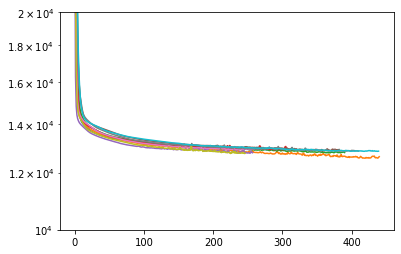

In [18]:
for vl in valid_losseses: 
    plt.plot(vl)
plt.yscale('log')
plt.ylim(1e4, 2e4)

In [19]:
print([np.min(vl) for vl in valid_losseses])

[12895.1869140625, 12565.73291015625, 12780.49599609375, 12900.28662109375, 12763.7630859375, 12869.25146484375, 12892.57919921875, 12848.7107421875, 12751.70009765625, 12841.880078125]


In [20]:
i_best = np.argmin([np.min(vl) for vl in valid_losseses])
best_flow = all_flows[i_best]

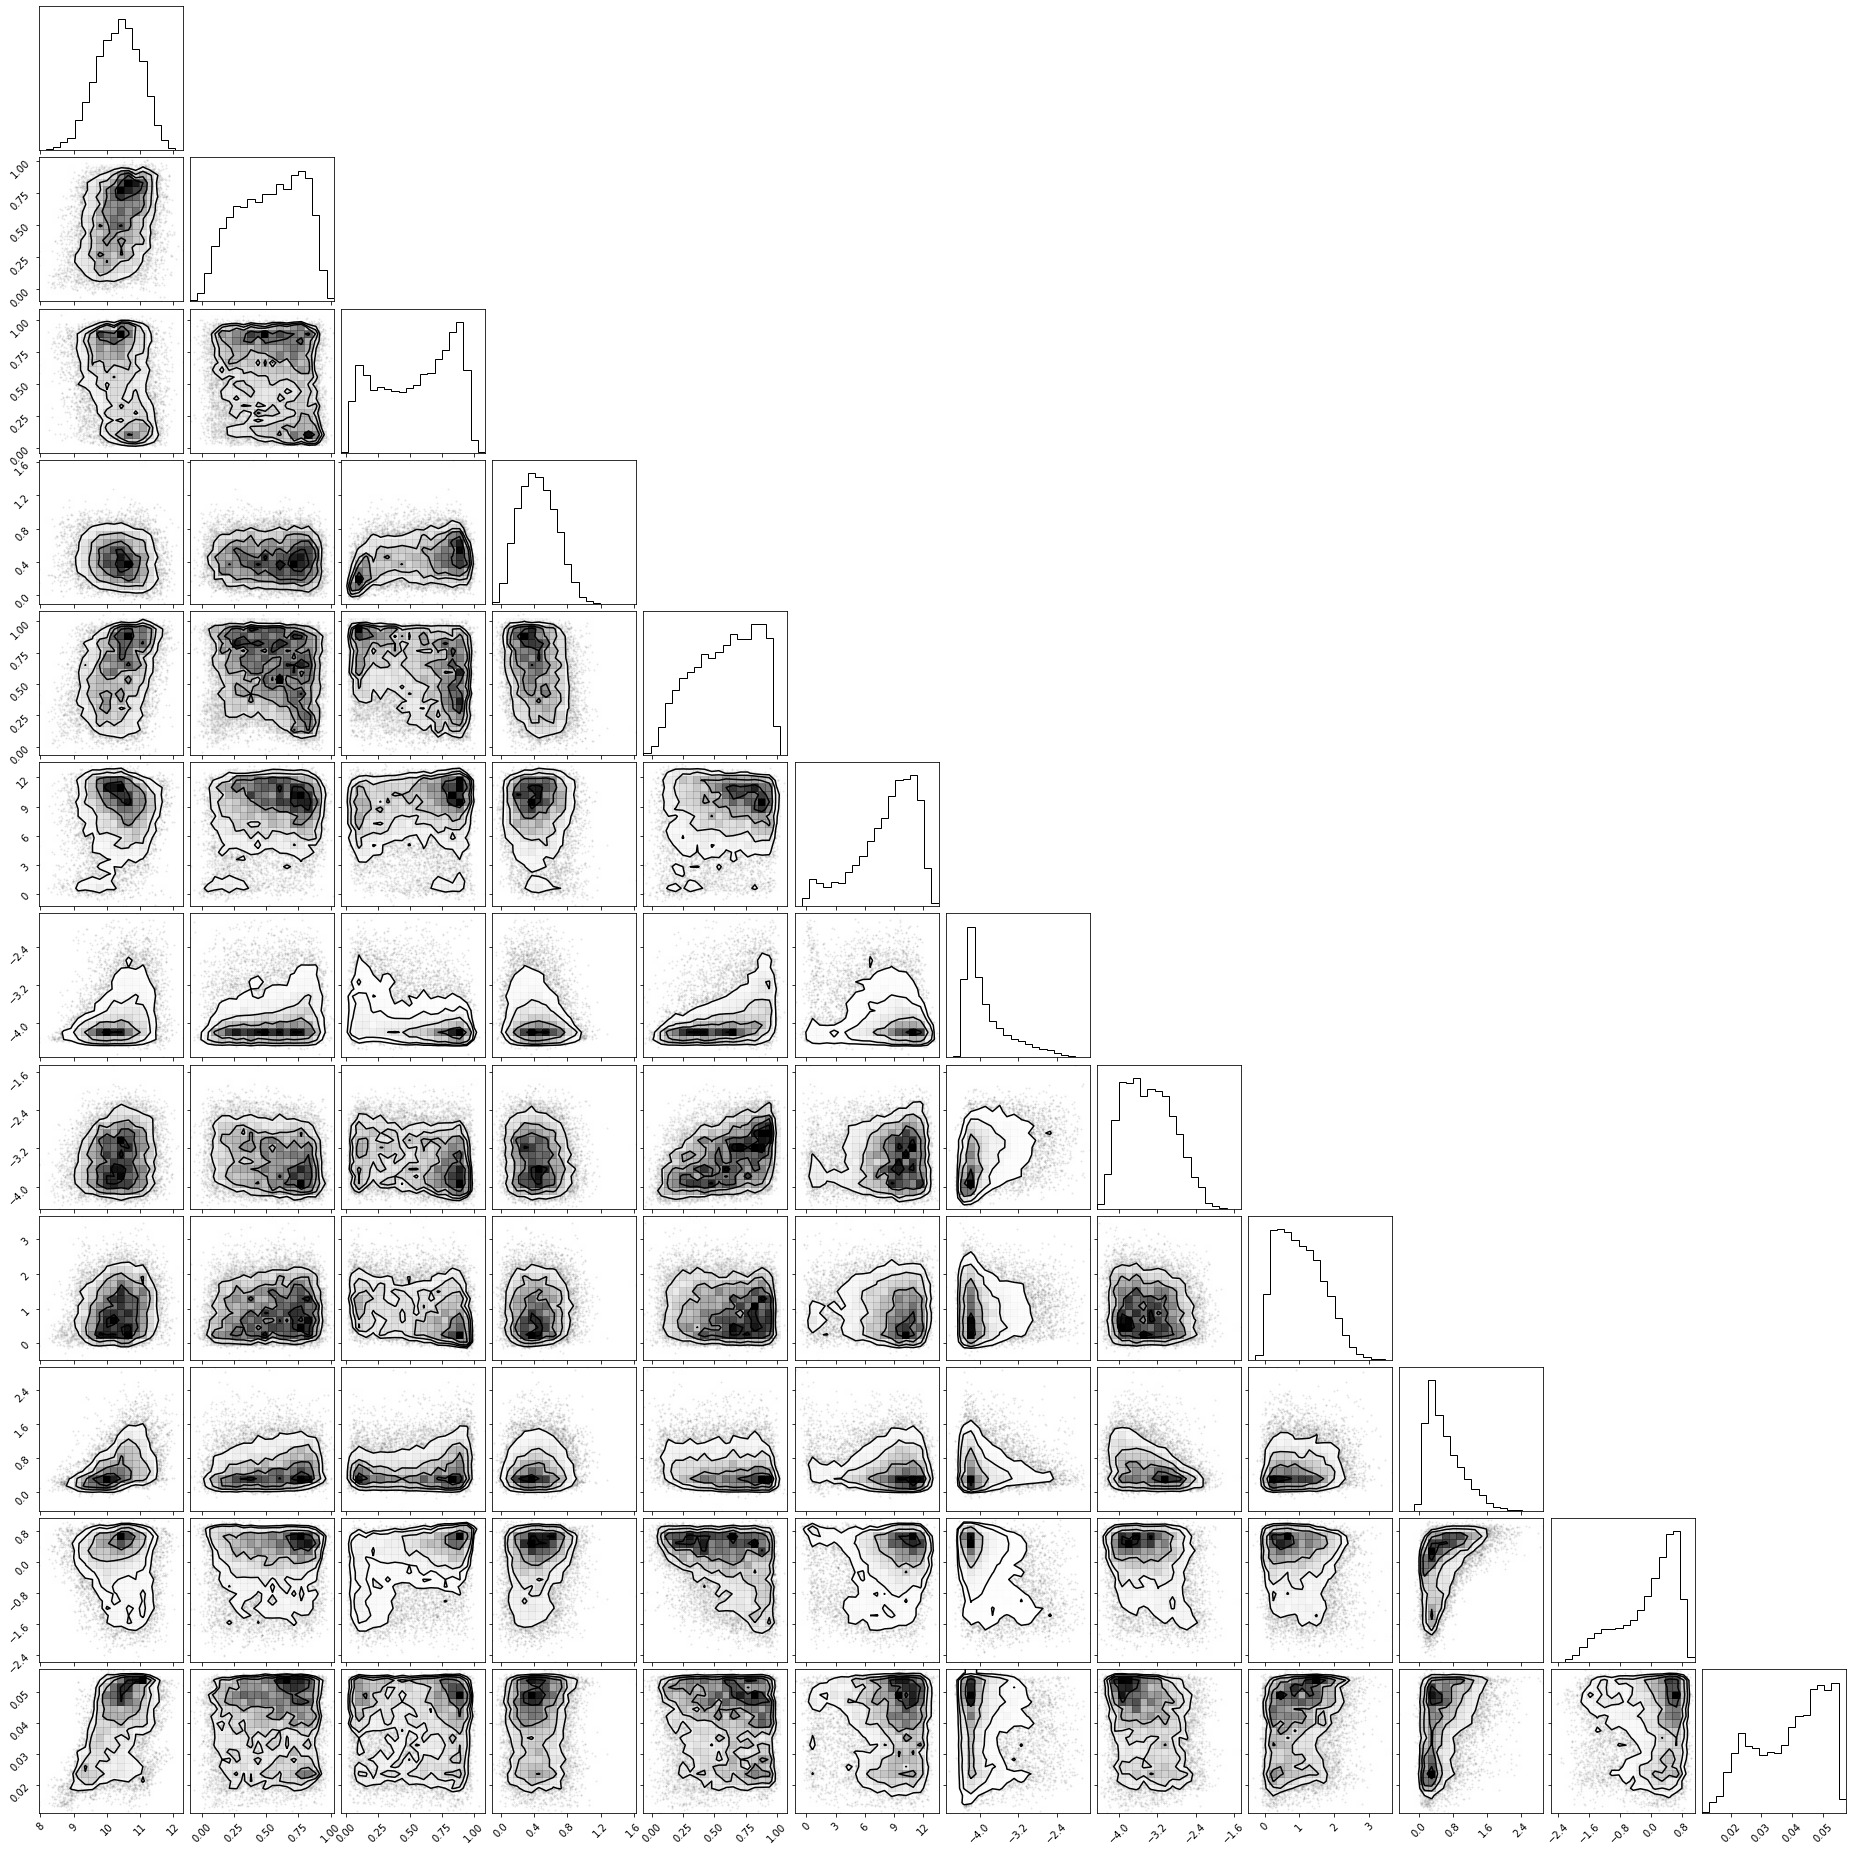

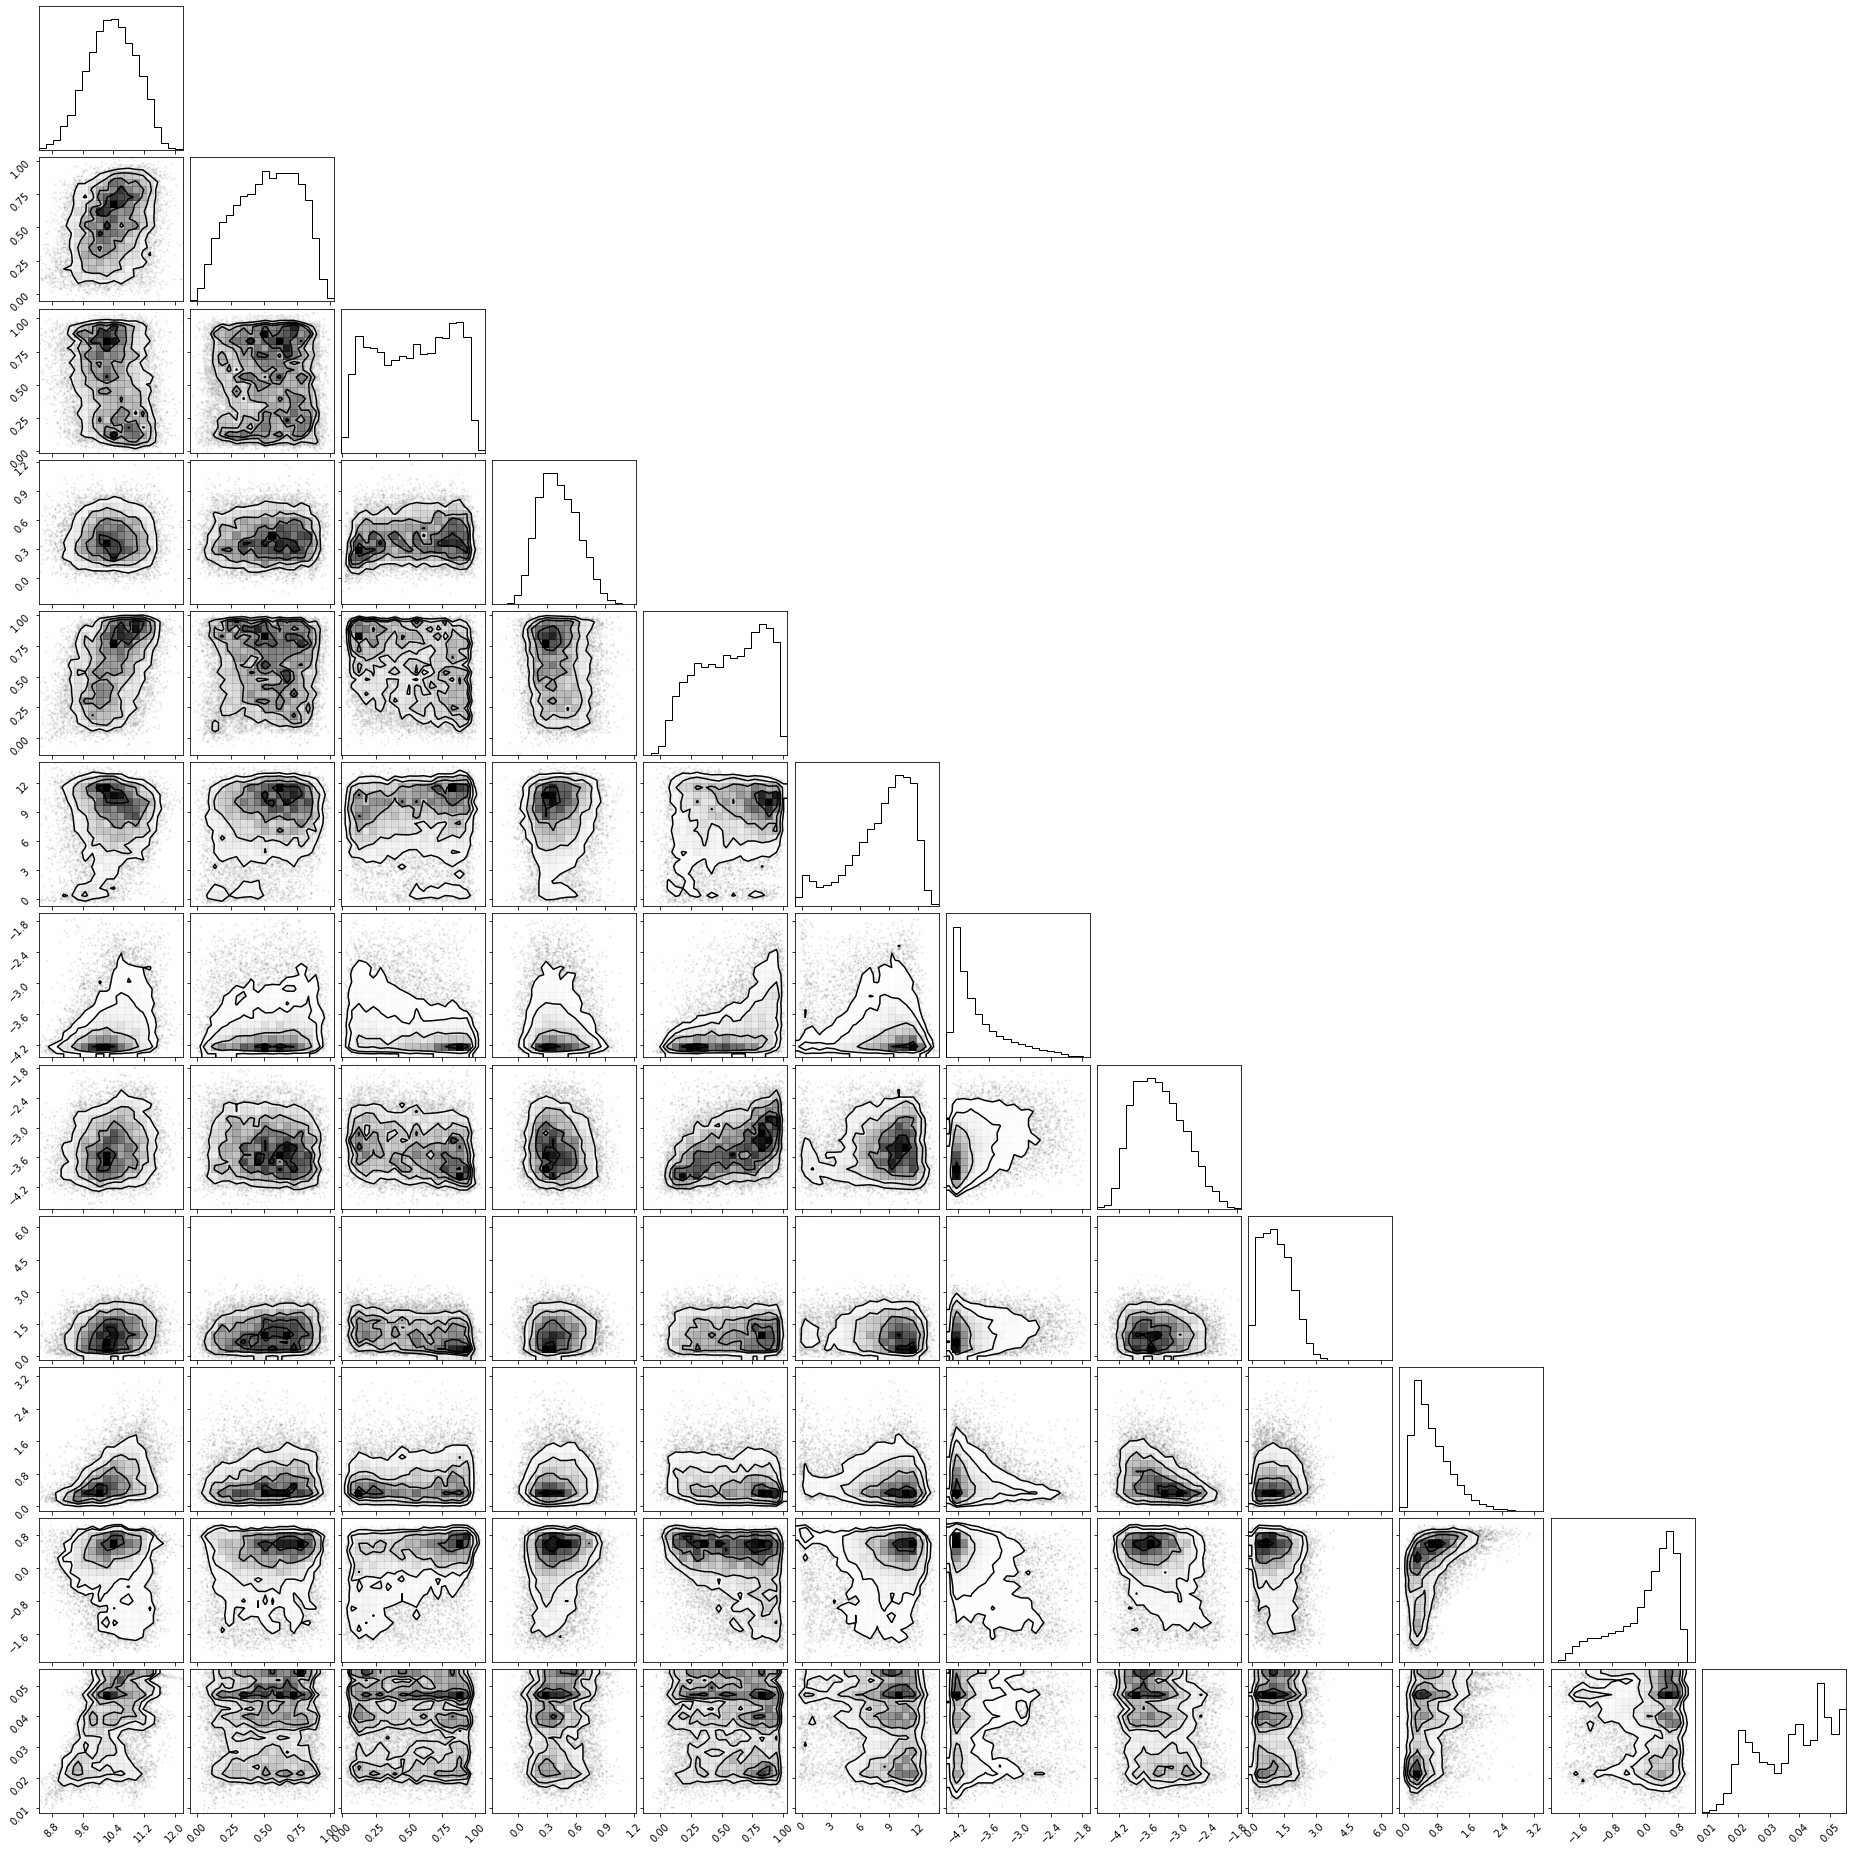

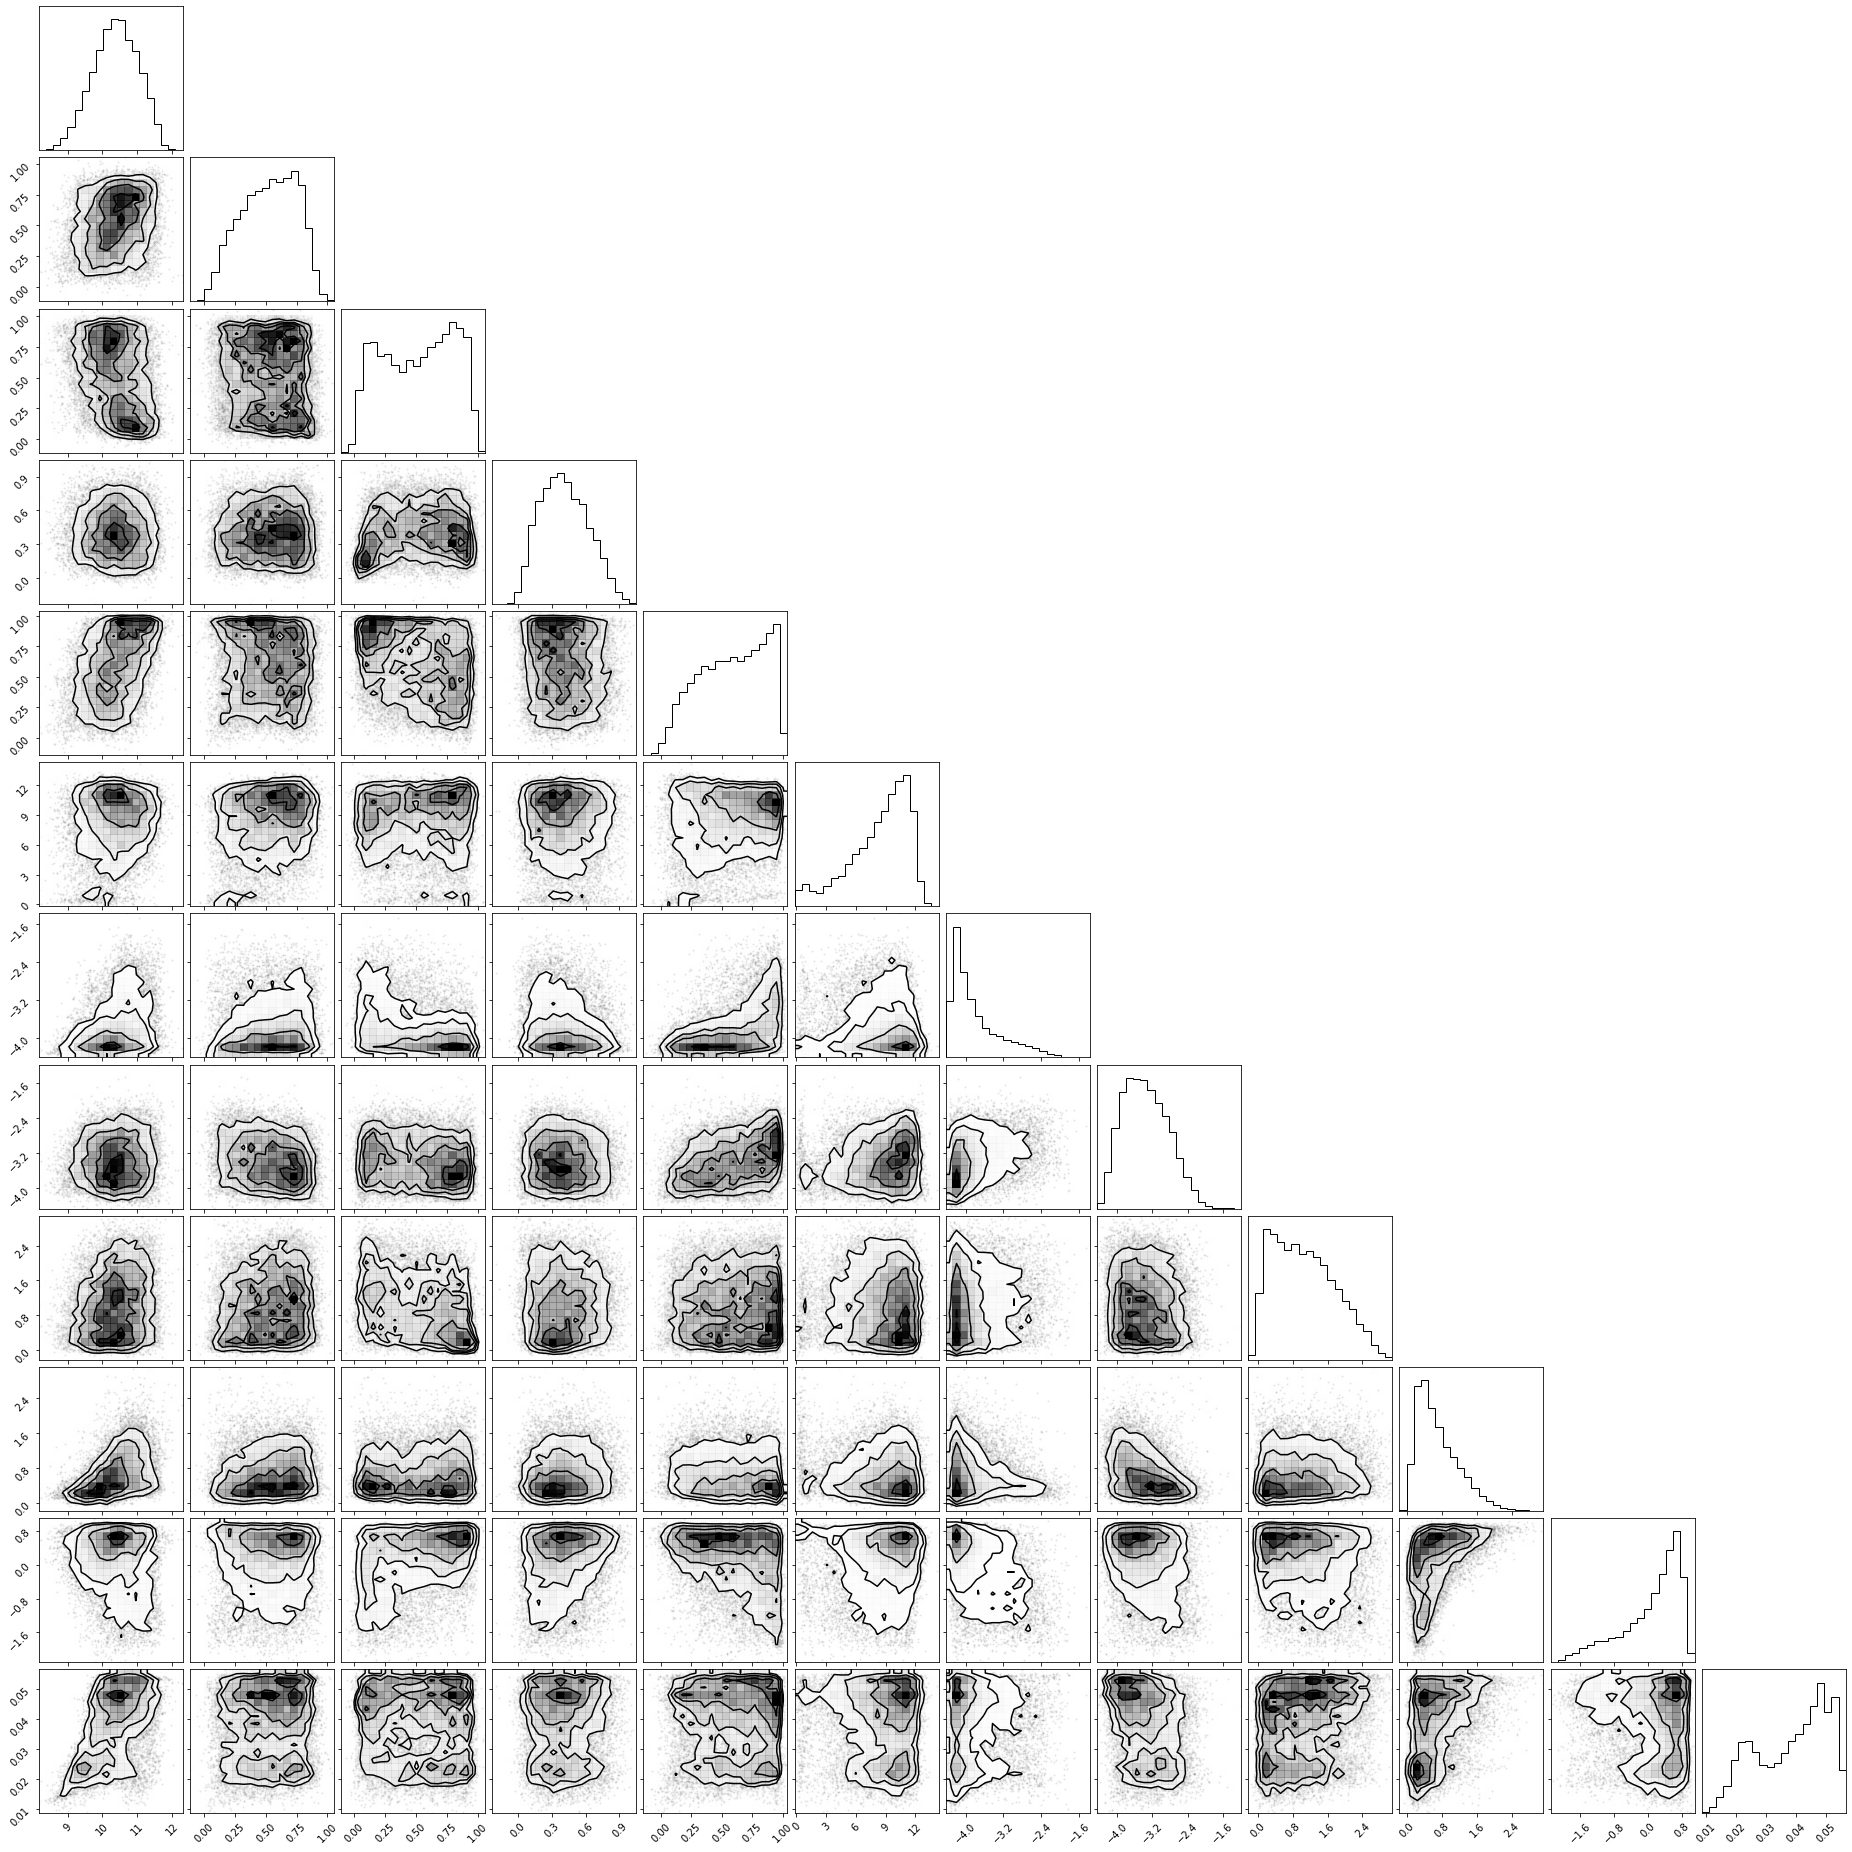

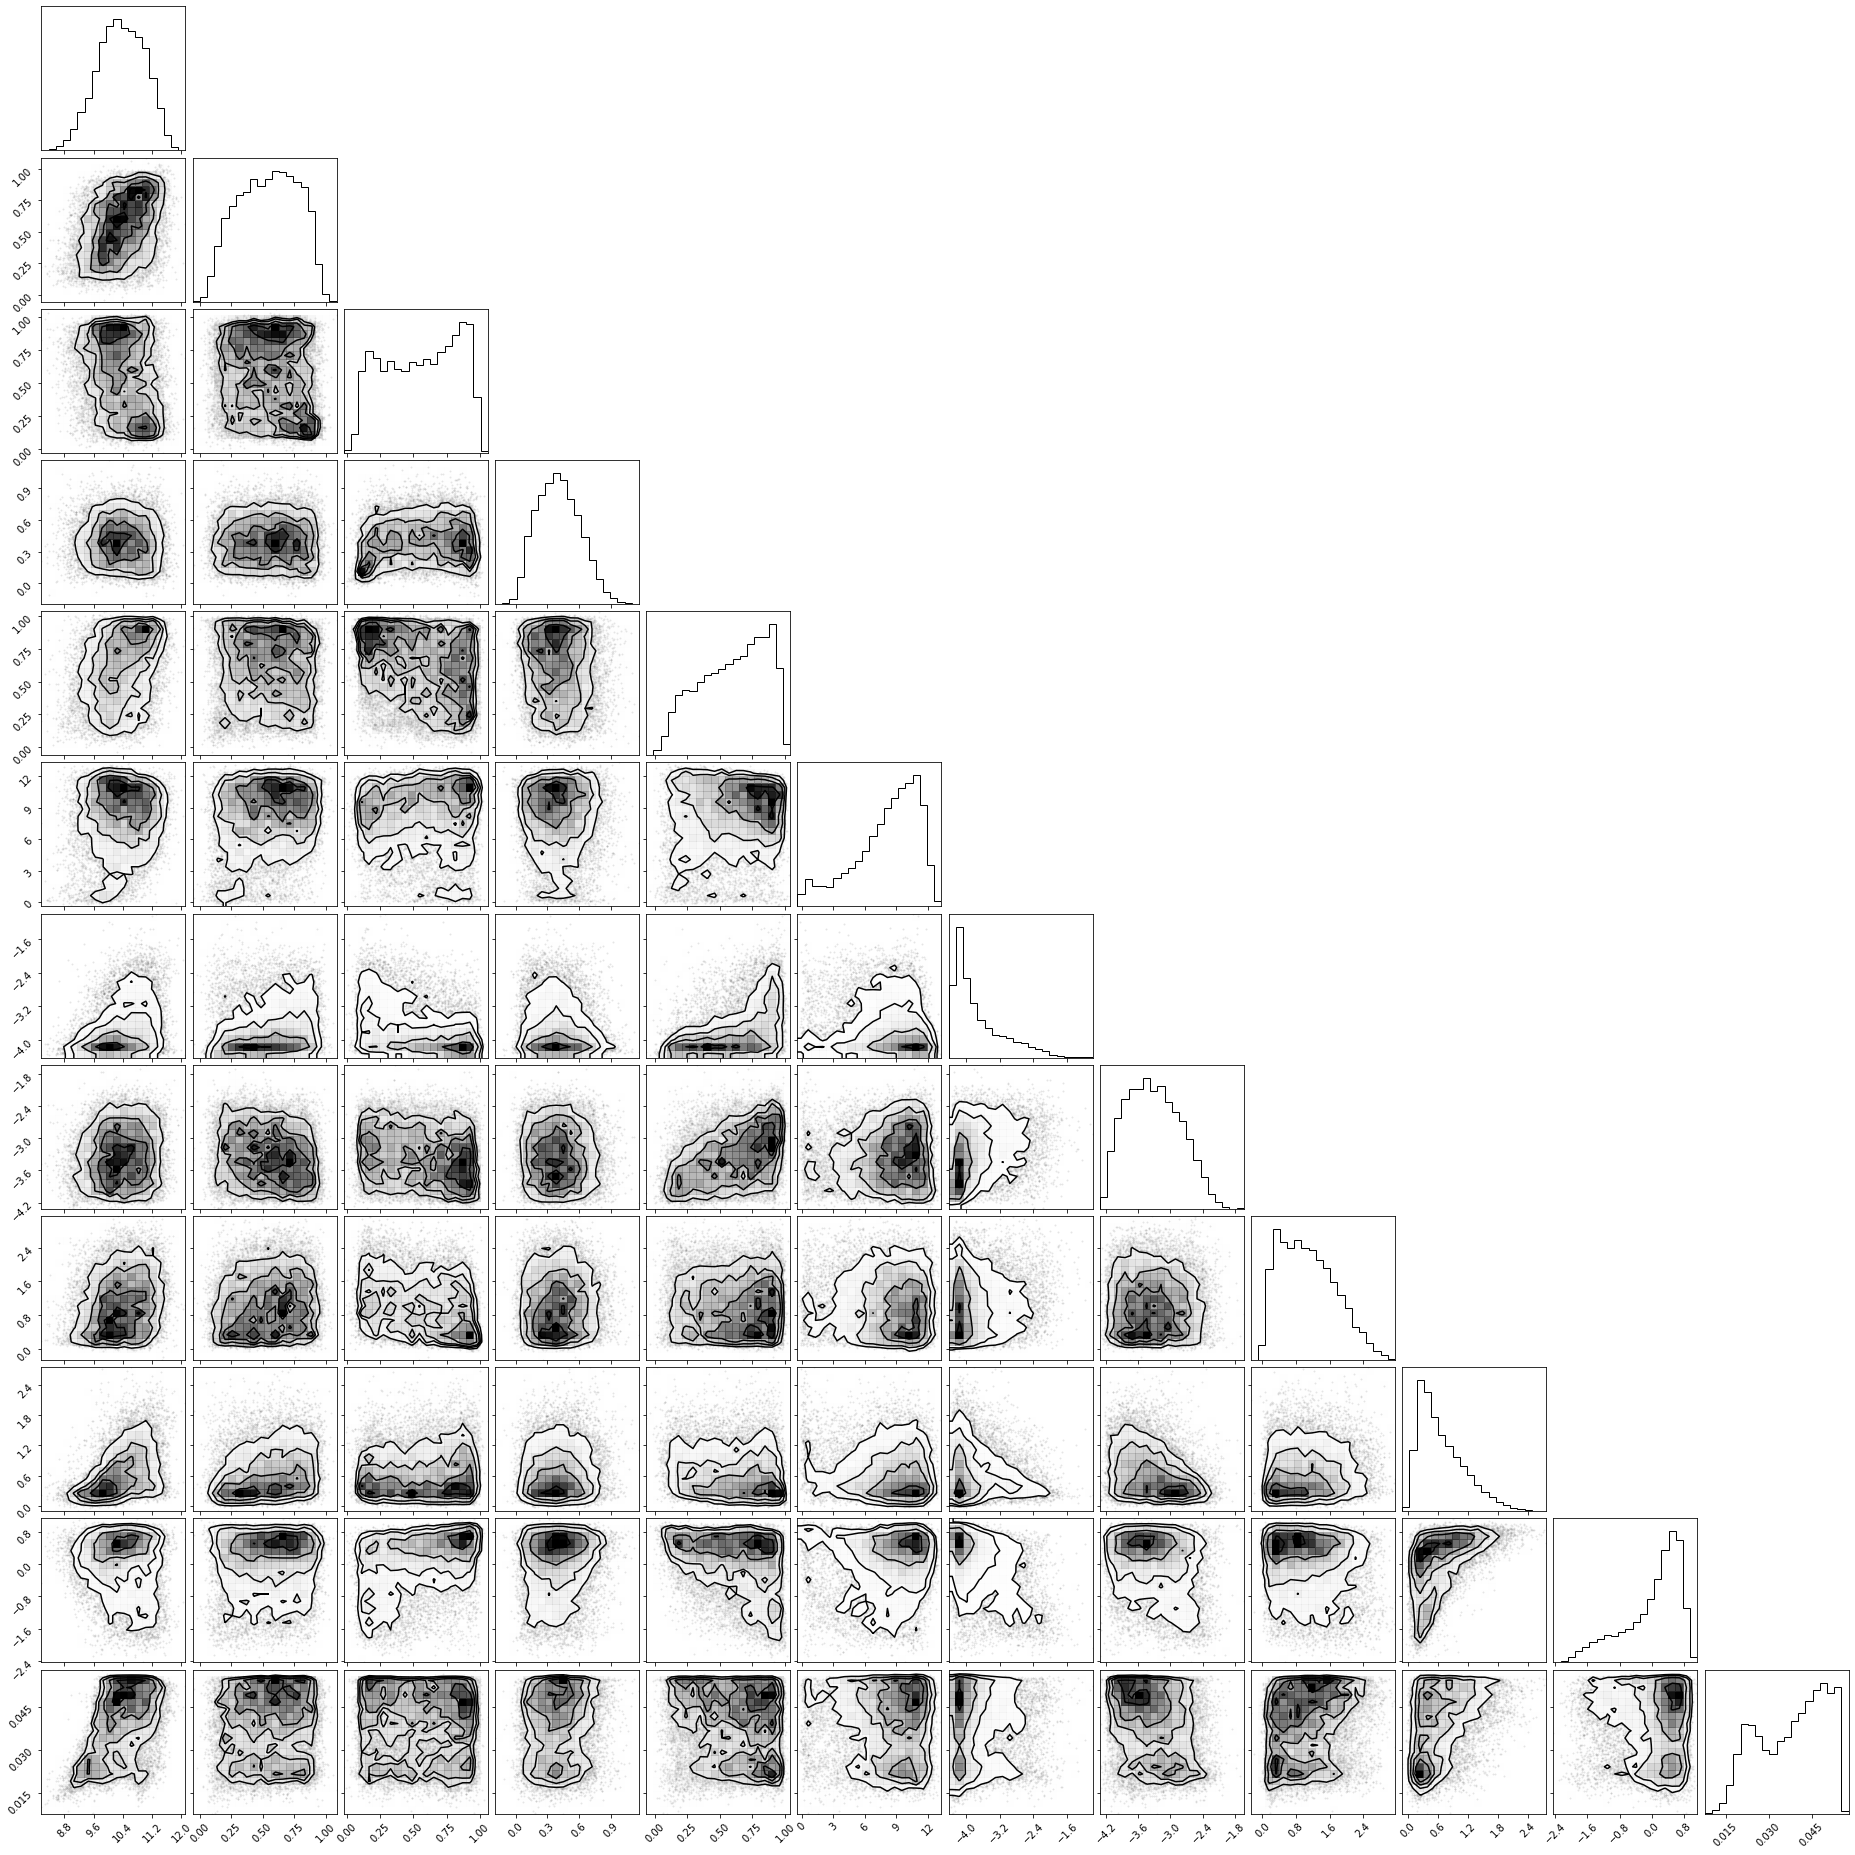

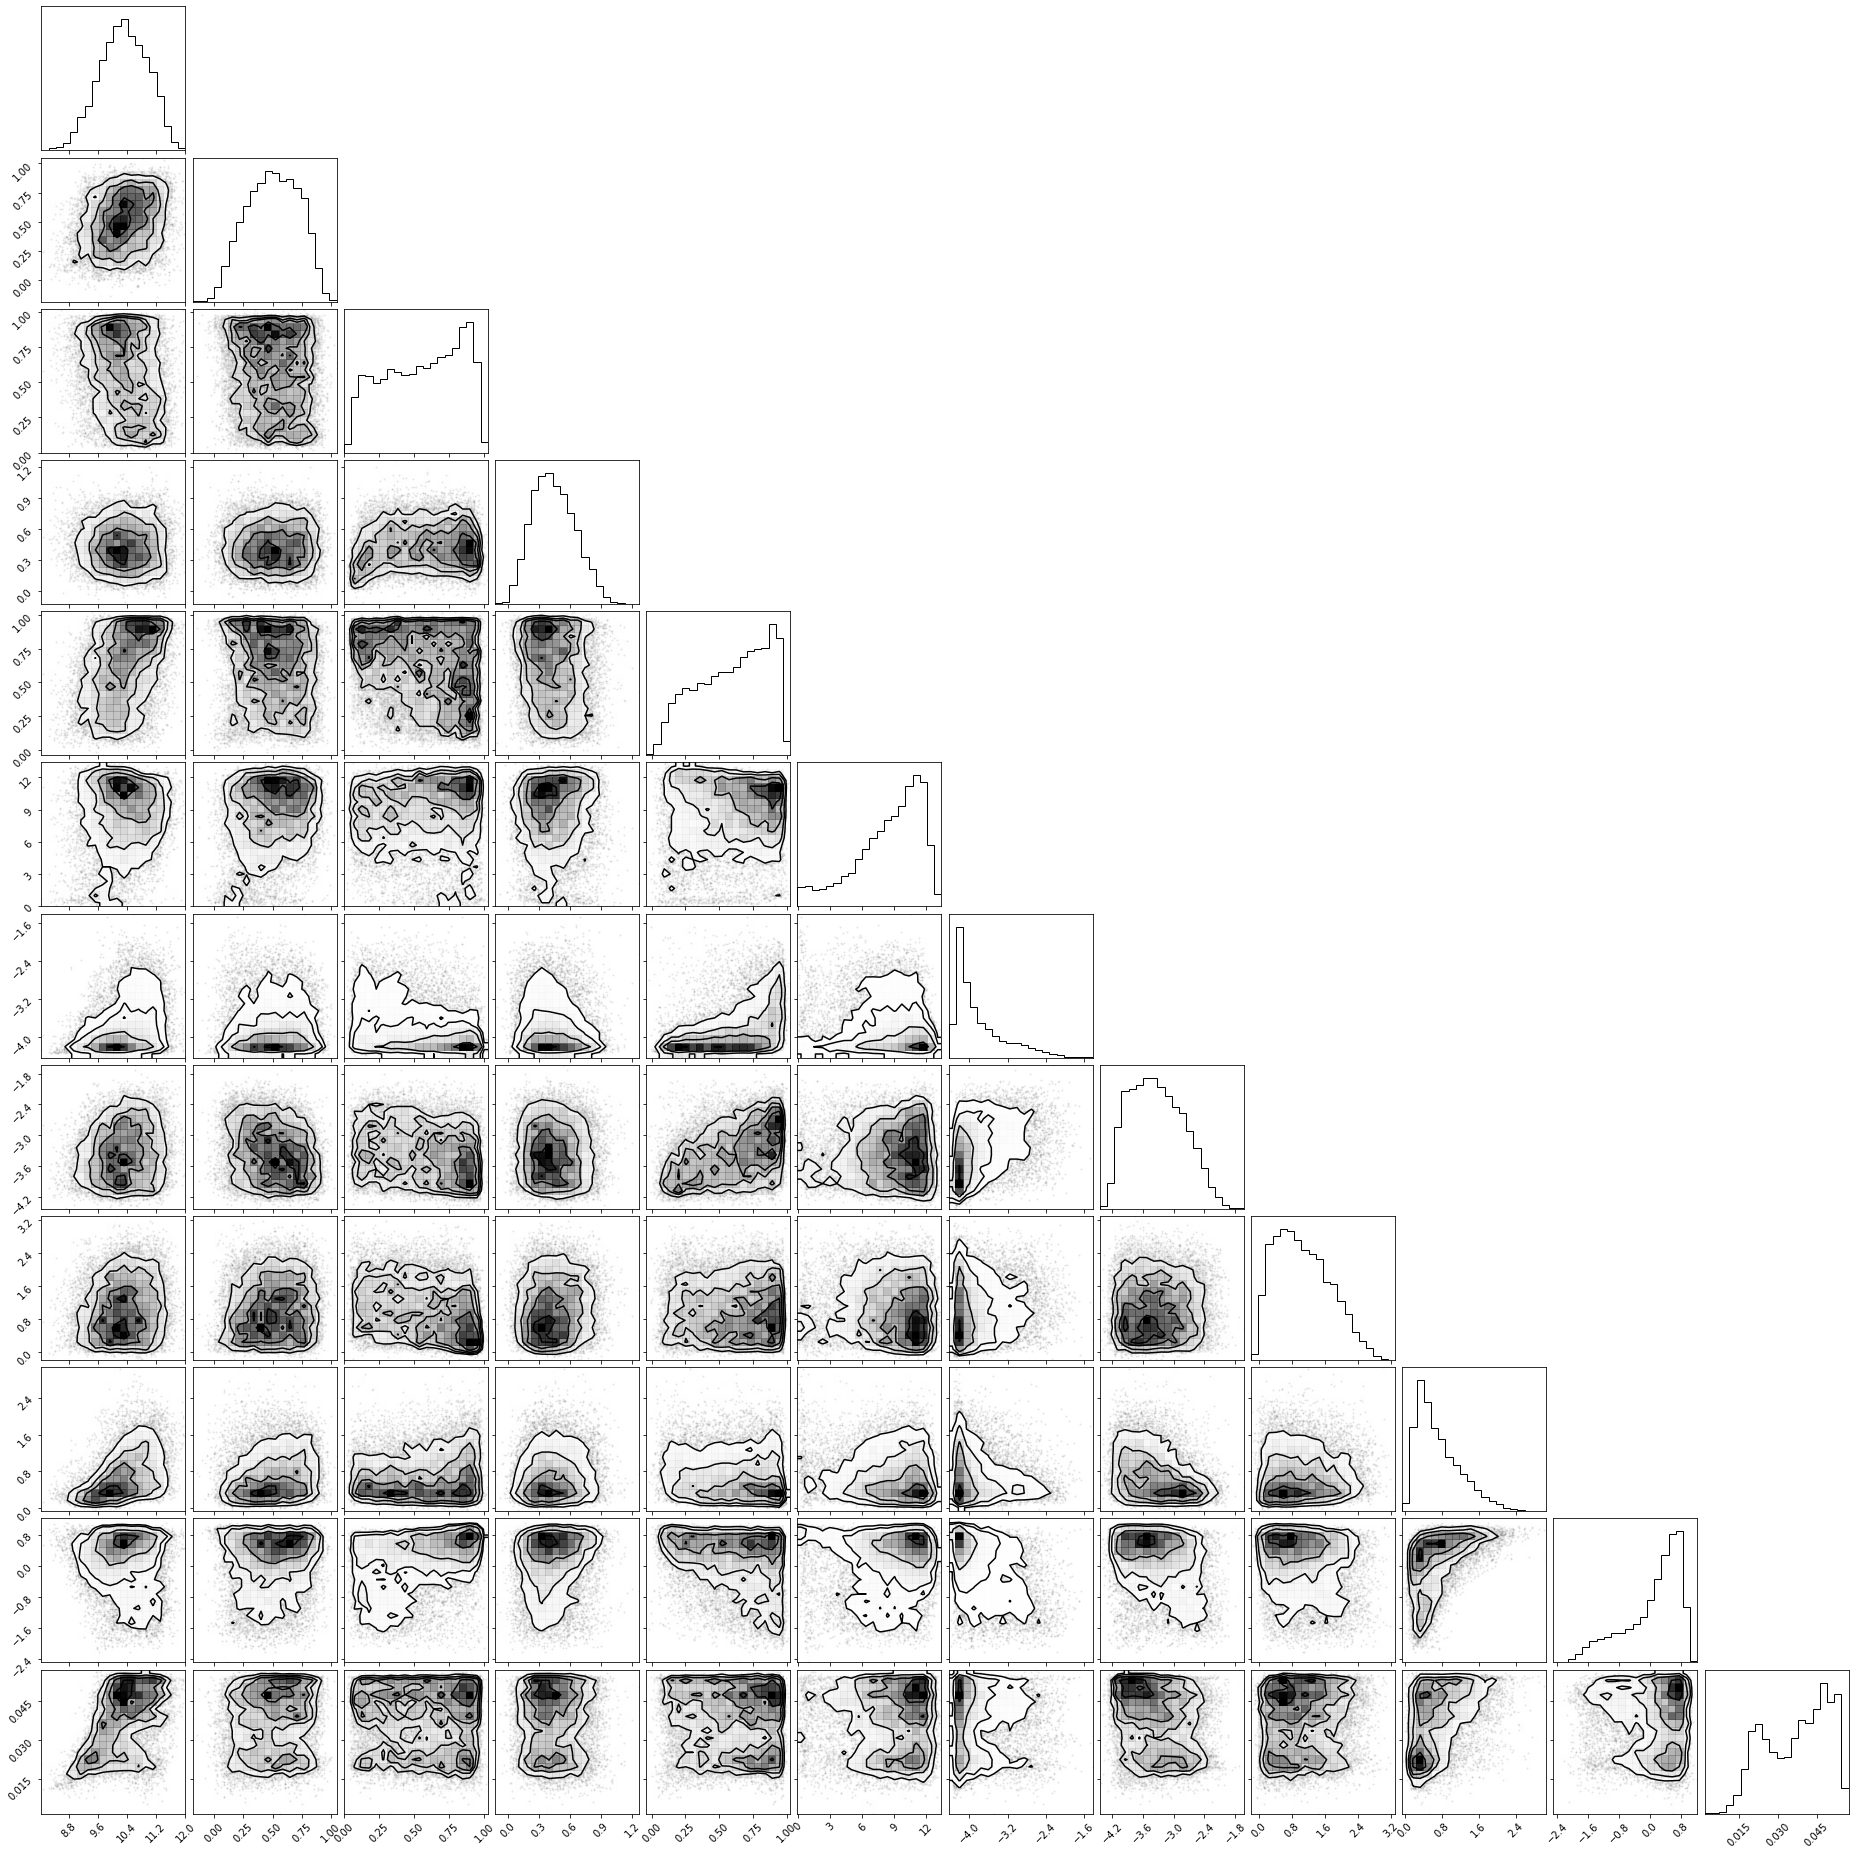

In [21]:
with torch.no_grad(): 
    for flow in all_flows[:5]:
        w_prime = flow.sample(10000)
        post_prime = w_prime * std_post + avg_post
        
        fig = DFM.corner(np.array(post_prime.cpu()))
        plt.show()

In [22]:
i_best = np.argmin([np.min(vl) for vl in valid_losseses])
best_flow = all_flows[i_best]
with torch.no_grad(): 
    w_prime = flow.sample(10000)
    post_prime = w_prime * std_post + avg_post
np.save(os.path.join(dat_dir, 'nsa_sedflow.posterior_combined.npy'), post_prime.cpu().numpy())